Using optimization approach: predict the configuration of dolphins with a group of 3, 4, 6, 8, and 10 dolphins

[[0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]
 [0. 0. 0.]]
[1.33311842 0.50571922 0.00548833]


RuntimeError: Error in qhull Delaunay triangulation calculation: singular input data (exitcode=2); use python verbose option (-v) to see original qhull error.

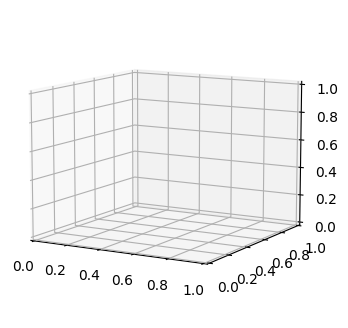

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from numpy import linalg as lin


class Nelder_Mead:
    def __init__(self, dim, dolphin_group, param=None):
        self.dim = dim
        self.simplex = np.zeros(dim*(dim + 1))
        self.simplex = np.reshape(self.simplex, (dim + 1, dim))
        self.param = param
        self.cost_func = dolphin_group  # fix the cost function
        self.val = np.zeros(dim + 1)
        
        # accepted values to use
        self.alpha = 1.0
        self.beta = 0.5
        self.gamma = 0.5
        self.delta = 0.5
        
        print(self.simplex)

    def get(self, index, entry=None):
        if entry is None:
            return self.val[index], self.simplex[index]
        else:
            self.simplex[index] = np.array(entry)
            if self.param == None:
                self.val[index] = self.cost_func(entry)
            else:
                self.val[index] = self.cost_func(entry, self.param)
            return self.val[index], self.simplex[index]

    def __getitem__(self, index):
        return self.get(index)

    def __setitem__(self, index, entry):
        return self.get(index, entry)

    def max_min(self):
        indices = np.argsort(self.val)
        return indices[-1], indices[0]

    def sorted_index(self, index):
        indices = np.argsort(self.val)
        return indices[index]

    def centroid(self):
        max, min = self.max_min()
        p_bar = np.zeros(self.dim)
        for i in range(max):
            p_bar += self.simplex[i]
        for i in range(max + 1, self.dim + 1):
            p_bar += self.simplex[i]

        p_bar = p_bar/self.dim
        return p_bar #, max

    def reflect(self, p_bar, p):
        return (1 + self.alpha) * p_bar - self.alpha * p

    def expand(self, p_bar, p):
        return self.gamma * p + (1 - self.gamma) * p_bar

    def contract(self, p_bar, p):
        return self.beta * p + (1 - self.beta) * p_bar

    def point_shrink(self, pl, p):
        return self.delta * p + (1 - self.delta) * pl

    def rmsd(self): # root mean square
        average = 0.0
        square_average = 0.0
        for entry in self.val:
            average += entry
            square_average += entry * entry
        average /= self.dim
        square_average /= self.dim
        return np.sqrt(np.abs(square_average - average*average))

    def nelder_mead_step(self): # modify this
        max_original, min_original = self.max_min()
        max_second = self.sorted_index(-2)
        p_bar = self.centroid()
        p_r = self.reflect(p_bar, self.simplex[max_original])

        if self.param == None:
            val_r = self.cost_func(p_r)
        else:
            val_r = self.cost_func(p_r, self.param)

        if val_r >= self.val[min_original] and val_r < self.val[max_second]:
            self.get(max_original, p_r)
            return self.val[min_original], min_original, self.rmsd(), 'reflect'

        if val_r < self.val[min_original]:
            p_ex = self.expand(p_bar, p_r)
            if self.param == None:
                val_ex = self.cost_func(p_ex)
            else:
                val_ex = self.cost_func(p_ex, self.param)

            if val_ex < val_r:
                self.get(max_original, p_ex)
                return val_ex, max_original, self.rmsd(), 'expand'

            else:
                self.get(max_original, p_r)
                return val_r, max_original, self.rmsd(), 'reflect'
        if val_r >= self.val[max_second]:
            if val_r < self.val[max_original]:
                p_c = self.contract(p_bar, p_r)
                if self.param == None:
                    val_c = self.cost_func(p_c)
                else:
                    val_c = self.cost_func(p_c, self.param)
                if val_c < val_r:
                    self.get(max_original, p_c)
                    return self.val[min_original], min_original, self.rmsd(), 'contract'
                else:
                    pl = self.simplex[min_original]
                    for i in range(min_original):
                        p_sh = self.point_shrink(pl, self.simplex[i])
                        self.get(i, p_sh)
                    for i in range(min_original + 1, self.dim + 1):
                        p_sh = self.point_shrink(pl, self.simplex[i])
                        self.get(i, p_sh)
                    return self.val[min_original], min_original, self.rmsd(), 'shrink'
            if val_r >= self.val[max_original]:
                p_c = self.contract(p_bar, self.simplex[max_original])
                if self.param == None:
                    val_c = self.cost_func(p_c)
                else:
                    val_c = self.cost_func(p_c, self.param)
                if val_c < self.val[max_original]:
                    self.get(max_original, p_c)
                    return self.val[min_original], min_original, self.rmsd(), 'contract2'
                else:
                    pl = self.simplex[min_original]
                    for i in range(min_original):
                        p_sh = self.point_shrink(pl, self.simplex[i])
                        self.get(i, p_sh)
                    for i in range(min_original + 1, self.dim + 1):
                        p_sh = self.point_shrink(pl, self.simplex[i])
                        self.get(i, p_sh)
                    return self.val[min_original], min_original, self.rmsd(), 'shrink'

    def optimize(self):
        rms = 1.0
        while rms > 1e-4:
            val, index, rms, step_name = self.nelder_mead_step()
            #print(val, index, rms, step_name)
        return nm.simplex[index]


def dolphin_group(x, p):
    #return (p[0]*x[0])**2 + (p[1]*x[1])**2
    #if dolphins too far away, cost = p**2
    #elif dolphins too close, cost = p**-2
    return (p[0] * x[0] - p[1]) **2 + (p[2] * x[1] - p[3]) **2 + (p[3] * x[2])**2
    
group_size = [3, 4, 6, 8, 10]
#param = [3.0, 4.0, 2.0, 1.0]
for i in group_size:
    nm = Nelder_Mead(3, dolphin_group, param) # 3 dim
    # 3n coordinates where n is the number of dolphins. find the cost function.
    # resize in numpy (convienent not needed)
    # cost function p^2 or p^-2
    # more than one solution is possible
    # 4 dolphins have one group tetrahedron
    v, s = nm.get(0, [0, 0, 0])  # value, simplex
    v, s = nm.get(1, [6, 0, 0])
    v, s = nm.get(2, [0, 3, 0])
    v, s = nm.get(3, [0, 0, 4])

    x = nm.optimize()
    print(x)
    
    X = np.arange(-5, 5, 0.25)
    Y = np.arange(-5, 5, 0.25)
    Z = np.arange(-5, 5, 0.25)
    XX = [[i for j in Y] for i in X]
    XX = [i for j in XX for i in j]
    
    YY = [[j for k in Z] for j in Y]
    YY = [j for k in YY for j in k]

    ZZ = [[k for i in X] for k in Z]
    ZZ = [k for i in ZZ for k in i]
    # xx yy and zz are indicies
    ZZ = [[[dolphin_group((i, j, k), group_size) for i in Y] for j in Z] for k in X]

    ZZ1 = [k for z in ZZ for k in z]

    fig = plt.figure(figsize=(8, 4))
    ax = plt.axes(projection="3d")
    ax.view_init(10, -60)
    surface = ax.plot_trisurf(YY, XX, ZZ1, cmap=cm.coolwarm, linewidth=0, antialiased=False)
    xp, yp, zp = x[0], x[1], x[2] # -50
    ax.scatter(xp, yp, zp)
    ax.contourf(X, Y, ZZ, offset=-50.0) ## ZZ used here
    ax.set_zlim([-50, 1000])
    ax.set_xlabel('x')
    ax.set_ylabel('y')
    plt.show()

    